In [87]:
# Ref: https://jaromiru.com/2016/10/03/lets-make-a-dqn-implementation/

#--- enable this to run on GPU
import os
os.environ['THEANO_FLAGS'] = "device=cuda*,floatX=float32"  

import random, numpy, math, gym

#-------------------- BRAIN ---------------------------
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

class Brain:
    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel()
        brain_wts = 'cartpole-basic.h5'
        if os.path.exists(brain_wts):
            self.model.load_weights("cartpole-basic.h5")

    def _createModel(self):
        model = Sequential()

        model.add(Dense(output_dim=64, activation='relu', input_dim=stateCnt))
        model.add(Dense(output_dim=actionCnt, activation='linear'))

        opt = RMSprop(lr=0.00025)
        model.compile(loss='mse', optimizer=opt)

        return model

    def train(self, x, y, epoch=1, verbose=0):
        self.model.fit(x, y, batch_size=64, nb_epoch=epoch, verbose=verbose)

    def predict(self, s):
        return self.model.predict(s)

    def predictOne(self, s):
        return self.predict(s.reshape(1, self.stateCnt)).flatten()

#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ )

    def __init__(self, capacity):
        self.samples = []
        self.capacity = capacity
        
    def __len__(self):
        return len(self.samples)

    def add(self, sample):
        self.samples.append(sample)        

        if len(self) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

#-------------------- AGENT ---------------------------
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.001      # speed of decay

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        else:
            return numpy.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):
#         # Don't trust experience till 1000 samples are observed!
#         if len(self.memory) > 10000:
#             print('Replaying from memory [{} samples]'.format(len(self.memory)))
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = numpy.zeros(self.stateCnt)

        states = numpy.array([ o[0] for o in batch ])
        states_ = numpy.array([ (no_state if o[3] is None else o[3]) for o in batch ])

        p = self.brain.predict(states)
        p_ = self.brain.predict(states_)

        x = numpy.zeros((batchLen, self.stateCnt))
        y = numpy.zeros((batchLen, self.actionCnt))

        for i in range(batchLen):
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]

            t = p[i]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * numpy.amax(p_[i])

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

#-------------------- ENVIRONMENT ---------------------
class Environment:
    def __init__(self, problem):
        self.problem = problem
        self.env = gym.make(problem)

    def run(self, agent):
        s = self.env.reset()
        R = 0

        while True:            
#             self.env.render()

            a = agent.act(s)

            s_, r, done, info = self.env.step(a)

            if done: # terminal state
                s_ = None

            agent.observe( (s, a, r, s_) )
            agent.replay()            

            s = s_
            R += r

            if done:
                break

        print("Total reward:", R)
        return R



In [92]:
#-------------------- MAIN ----------------------------

PROBLEM = 'CartPole-v0'
env = Environment(PROBLEM)

stateCnt  = env.env.observation_space.shape[0]
actionCnt = env.env.action_space.n

agent = Agent(stateCnt, actionCnt)

episode_rewards = []

try:
    while True:
        R = env.run(agent)
        episode_rewards.append(R)
finally:
    pass
#     agent.brain.model.save("cartpole-basic.h5")


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=4, units=64)`
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=2)`
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Total reward: 11.0
Total reward: 21.0
Total reward: 57.0
Total reward: 33.0
Total reward: 18.0
Total reward: 16.0
Total reward: 54.0
Total reward: 30.0
Total reward: 60.0
Total reward: 20.0
Total reward: 72.0
Total reward: 93.0
Total reward: 72.0
Total reward: 18.0
Total reward: 16.0
Total reward: 85.0
Total reward: 41.0
Total reward: 103.0
Total reward: 182.0
Total reward: 200.0
Total reward: 158.0
Total reward: 200.0
Total reward: 177.0
Total reward: 200.0
Total reward: 166.0
Total reward: 200.0
Total reward: 167.0
Total reward: 185.0
Total reward: 160.0
Total reward: 185.0
Total reward: 149.0
Total reward: 161.0
Total reward: 162.0
Total reward: 156.0
Total reward: 195.0
Total reward: 164.0
Total reward: 161.0
Total reward: 135.0
Total reward: 151.0
Total reward: 155.0
Total reward: 159.0
Total reward: 153.0
Total reward: 152.0
Total reward: 141.0
Total reward: 178.0
Total reward: 168.0
Total reward: 174.0
Total reward: 140.0
Total reward: 179.0
Total reward: 129.0
Total reward: 162

KeyboardInterrupt: 

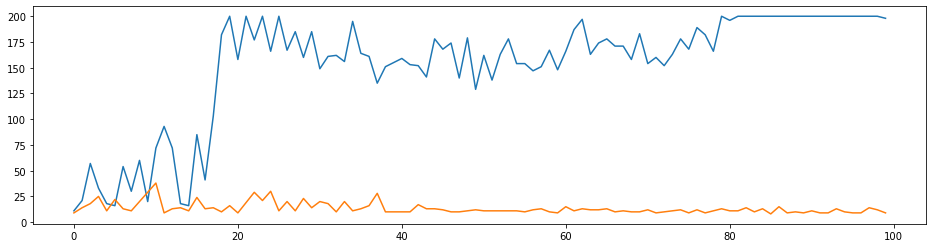

In [98]:
from matplotlib import pyplot as plt

# naive_episode_rewards = episode_rewards[:]

fig, ax = plt.subplots()
fig.set_size_inches((16, 4))
ax.plot(episode_rewards[:100])

ax.plot(naive_episode_rewards[:100])


In [ ]:
len(agent.memory)

In [ ]:
env.env.spec.max_episode_steps

In [ ]:
env.env.spec.reward_threshold

In [31]:
prob.env